In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [116]:
df  = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [117]:
df.isnull().values.any()

True

In [118]:
def missing_values_first_look(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    miss_n = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_values_df = pd.concat([miss_n, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_values_df)

    if na_name:
        return na_cols

In [119]:
missing_values_first_look(df)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


# Eksik Değer(Missing Value) Problemini Çözme

Burada problemimizi çözerken eksik değerlerimizin raslantısal oluşup oluşmadığını anlamamız gerekir.

1. Silmek
2. Basit Atama Yöntemleri ile Doldurma (mean,median,mod,sabit bir değer)
3. Tahmine Dayalı Atama İşlemi

In [69]:
train_df=df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0).head()
missing_values_first_look(train_df)

       n_miss  ratio
Cabin       3   60.0


In [120]:
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [109]:
df.loc[(df["Age"].isnull()) & (df["Sex"]=="female"), "Age"] = df.groupby("Sex")["Age"].mean()["female"]
df.loc[(df["Age"].isnull()) & (df["Sex"]=="male"), "Age"] = df.groupby("Sex")["Age"].mean()["male"]
missing_values_first_look(df)

          n_miss  ratio
Cabin        687  77.10
Embarked       2   0.22


In [121]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
  
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [122]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [123]:
df2 = pd.get_dummies(df[cat_cols + num_cols], drop_first = True)
df2.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,1,0,22.0,7.2500,1,0,1
1,1,1,1,0,38.0,71.2833,0,0,0
2,1,3,0,0,26.0,7.9250,0,0,1
3,1,1,1,0,35.0,53.1000,0,0,1
4,0,3,0,0,35.0,8.0500,1,0,1


In [124]:
scaler = MinMaxScaler()
df2 = pd.DataFrame(scaler.fit_transform(df2),columns=df2.columns)
df2.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,1.0,0.125,0.0,0.271174,0.014151,1.0,0.0,1.0
1,1.0,0.0,0.125,0.0,0.472229,0.139136,0.0,0.0,0.0
2,1.0,1.0,0.000,0.0,0.321438,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.125,0.0,0.434531,0.103644,0.0,0.0,1.0
4,0.0,1.0,0.000,0.0,0.434531,0.015713,1.0,0.0,1.0


In [125]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df2 = pd.DataFrame(imputer.fit_transform(df2),columns=df2.columns)
df2.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,1.0,0.125,0.0,0.271174,0.014151,1.0,0.0,1.0
1,1.0,0.0,0.125,0.0,0.472229,0.139136,0.0,0.0,0.0
2,1.0,1.0,0.000,0.0,0.321438,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.125,0.0,0.434531,0.103644,0.0,0.0,1.0
4,0.0,1.0,0.000,0.0,0.434531,0.015713,1.0,0.0,1.0


In [126]:
df2 = pd.DataFrame(scaler.inverse_transform(df2),columns = df2.columns)
df['Age_Imputed_KNN'] = df2[['Age']]
df.loc[df["Age"].isnull(),["Age","Age_Imputed_KNN"]]


,Age,Age_Imputed_KNN
5,NaN,47.8
17,NaN,37.6
19,NaN,12.2
26,NaN,32.8
28,NaN,17.6
...,...,...
859,NaN,25.8
863,NaN,8.8
868,NaN,25.0
878,NaN,24.4


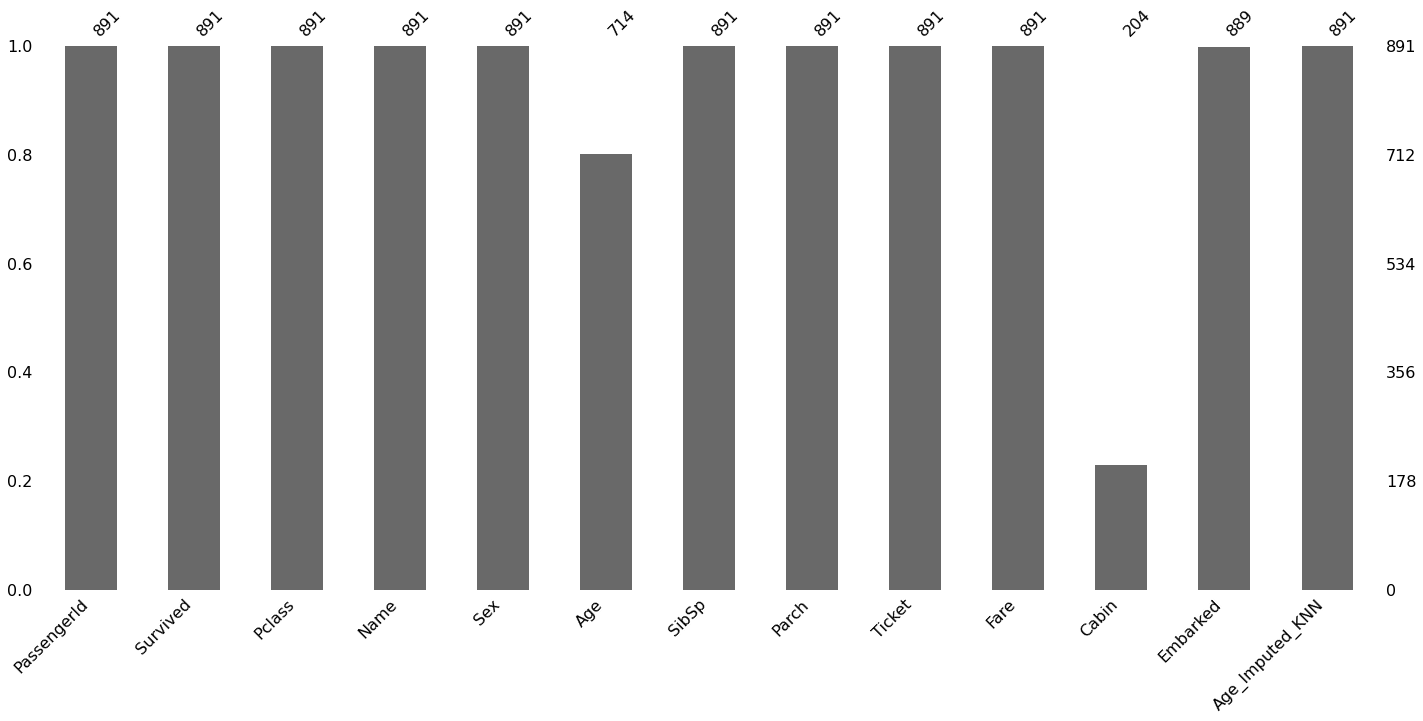

In [127]:
msno.bar(df)
plt.show()

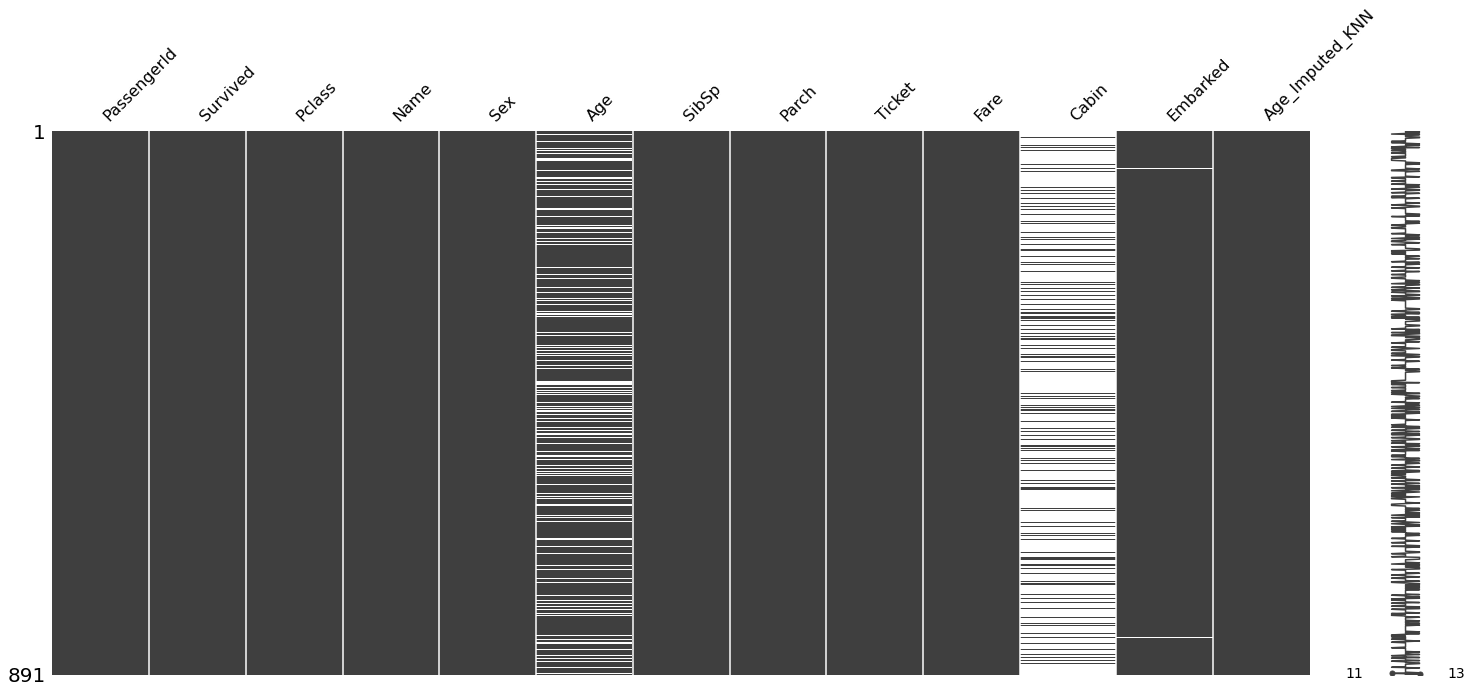

In [128]:
msno.matrix(df)
plt.show()

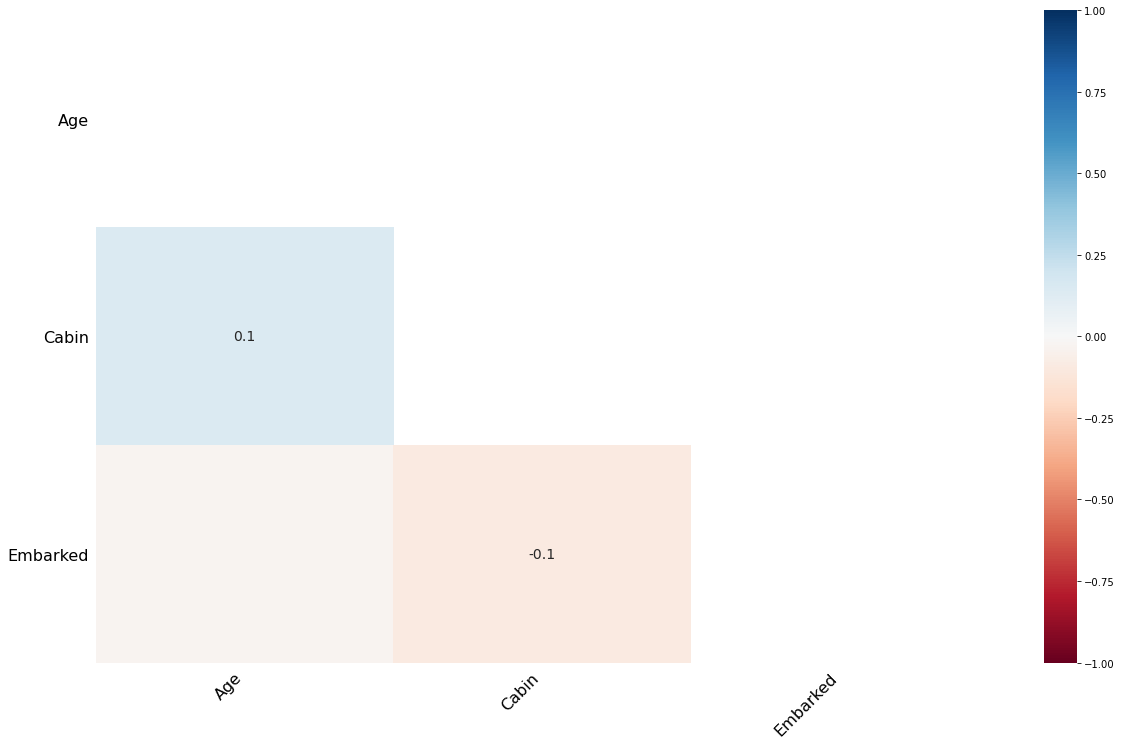

In [129]:
msno.heatmap(df)
plt.show()

In [130]:
def missing_graphs(df):
    msno.bar(df)
    msno.heatmap(df)
    msno.matrix(df)
    plt.show()

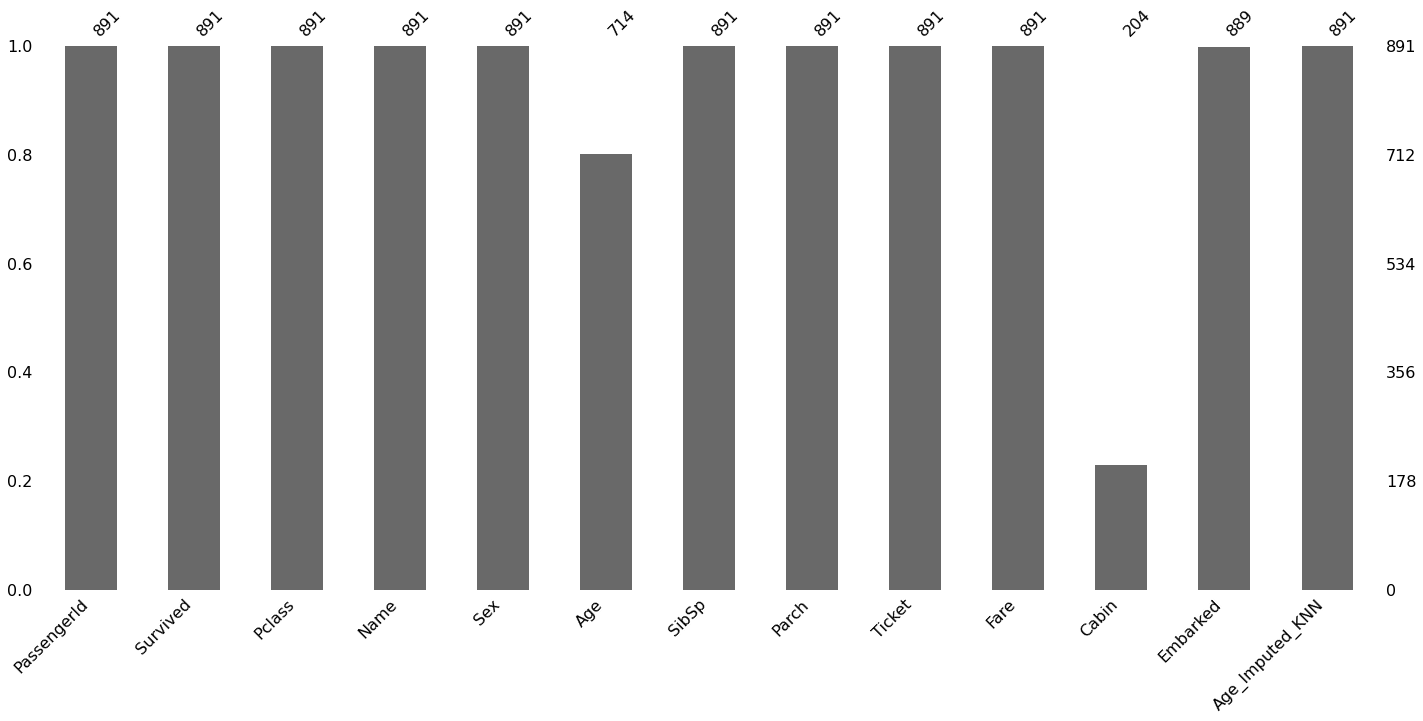

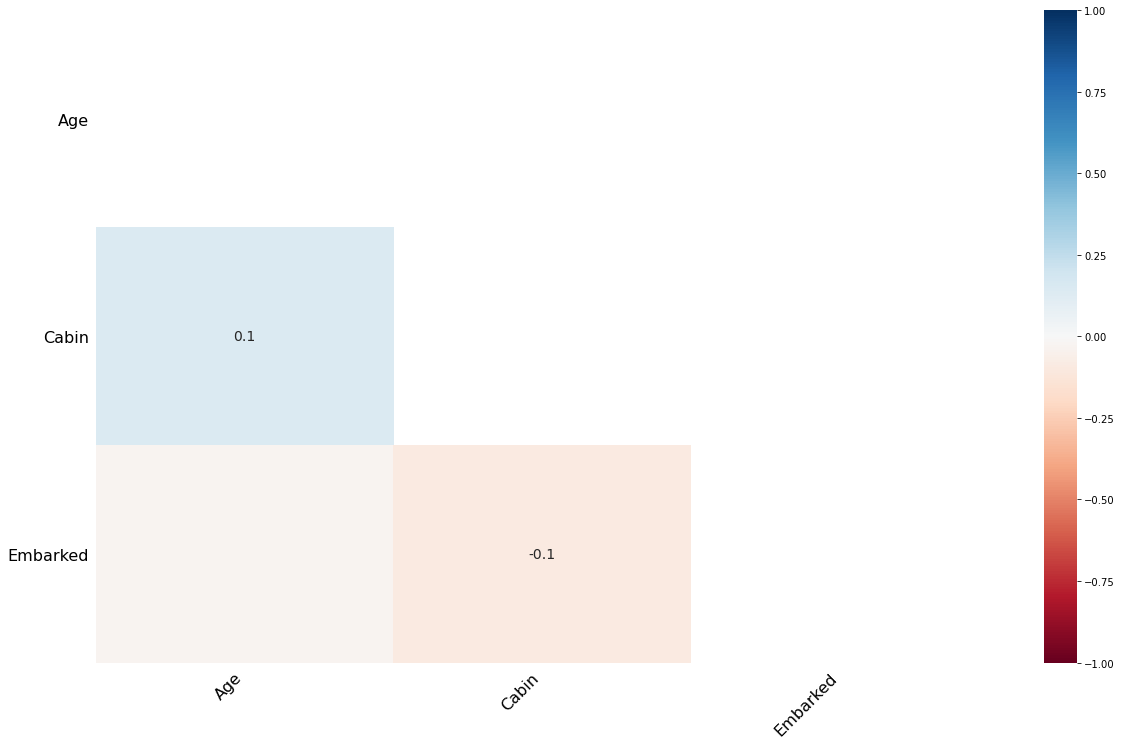

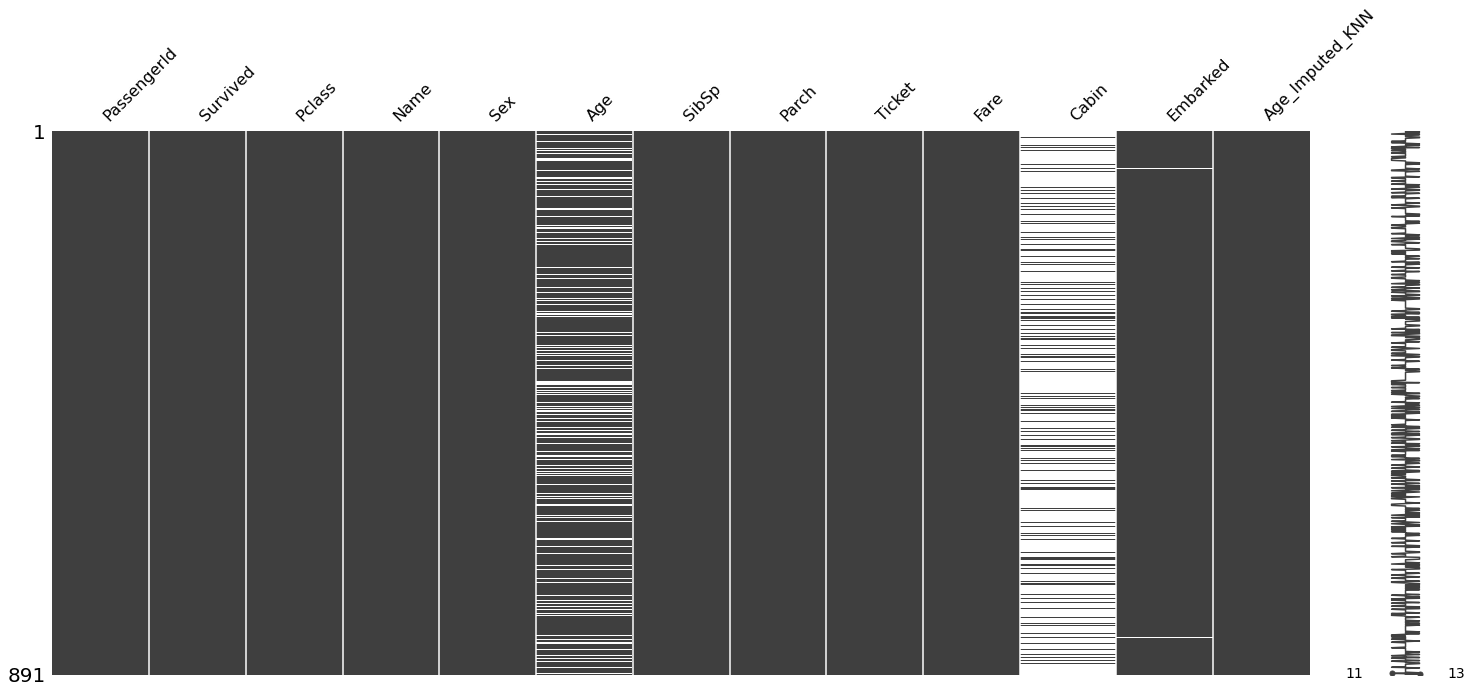

In [131]:
missing_graphs(df)

In [134]:
def last_analysis(dataframe,target,na_columns):
    df_c = dataframe.copy()
    for col in na_columns:
        df_c[col + '_NA_FLAG'] = np.where(df_c[col].isnull(),1,0)
    na_flags = df_c.loc[:, df_c.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"Target_Mean": df_c.groupby(col)[target].mean(), "Count": df_c.groupby(col)[target].count()}))
    
nan_cols = missing_values_first_look(df,True)

last_analysis(df,"Survived",nan_cols)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22
             Target_Mean  Count
Age_NA_FLAG                    
0               0.406162    714
1               0.293785    177
               Target_Mean  Count
Cabin_NA_FLAG                    
0                 0.666667    204
1                 0.299854    687
                  Target_Mean  Count
Embarked_NA_FLAG                    
0                    0.382452    889
1                    1.000000      2
